In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pickle

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

In [7]:
df = pd.read_csv("data/combined_labeled_data_clean.csv")

In [8]:
print(f"Dataset shape: {df.shape}")
print("\nColumn information:")
print(df.info())
print("\nClass distribution:")
print(df['Label'].value_counts())

Dataset shape: (800, 6)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   score        800 non-null    float64
 1   selftext     800 non-null    object 
 2   subreddit    800 non-null    object 
 3   title        800 non-null    object 
 4   Label        800 non-null    object 
 5   source_file  800 non-null    object 
dtypes: float64(1), object(5)
memory usage: 37.6+ KB
None

Class distribution:
Label
Drug and Alcohol      184
Personality           182
Trauma and Stress     127
Early life            112
Early Life             80
Trauma and Stress      72
personality            18
drug and alcohol       11
early life              8
drug and Alcohol        3
Drug and alcohol        2
trauma and stress       1
Name: count, dtype: int64


In [9]:
# Clean the 'Label' column
df['Label'] = df['Label'].str.lower()
df['Label'] = df['Label'].str.strip()

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Verify the cleaning process
print("Unique values and their frequencies in the 'Label' column:")
print(df['Label'].value_counts())
print("\nShape of the DataFrame after removing duplicates:", df.shape)

Unique values and their frequencies in the 'Label' column:
Label
drug and alcohol     200
early life           200
personality          200
trauma and stress    200
Name: count, dtype: int64

Shape of the DataFrame after removing duplicates: (800, 6)


In [10]:
PLOT_DIRECTORY = 'visualization'

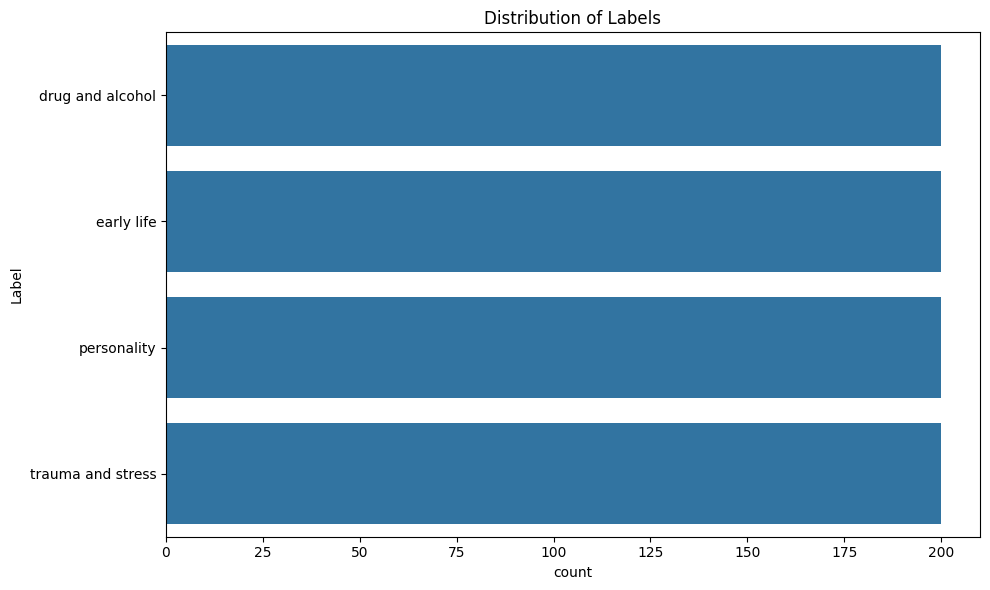

In [13]:
label_counts = df['Label'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(y='Label', data=df)
plt.title('Distribution of Labels')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distribution_of_Labels.png"), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
label_percentages = (label_counts / len(df)) * 100
print("Percentage of each label:\n", label_percentages)

Percentage of each label:
 Label
drug and alcohol     25.0
early life           25.0
personality          25.0
trauma and stress    25.0
Name: count, dtype: float64


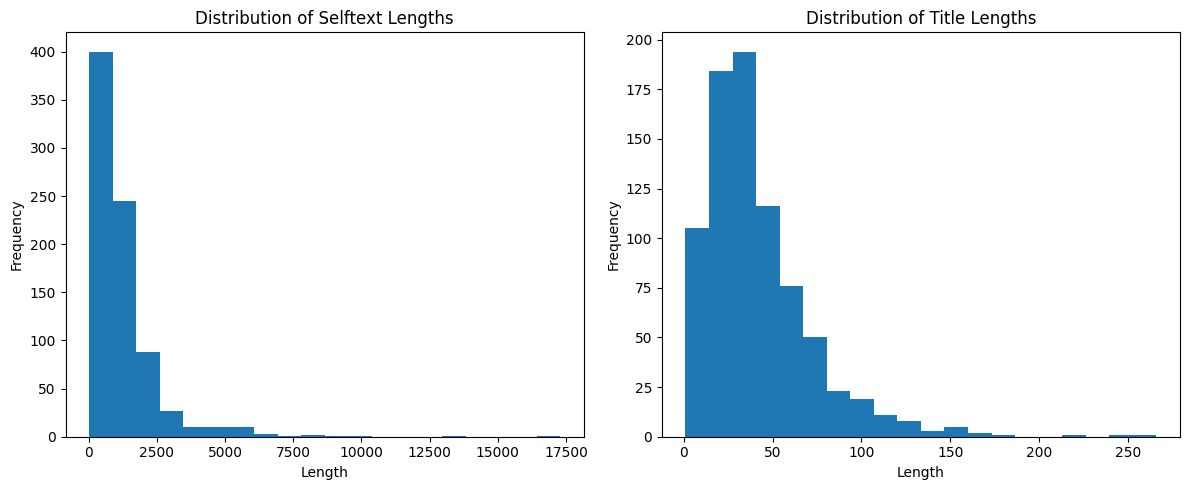

In [15]:
df['selftext_length'] = df['selftext'].str.len()
df['title_length'] = df['title'].str.len()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['selftext_length'], bins=20)
plt.title('Distribution of Selftext Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['title_length'], bins=20)
plt.title('Distribution of Title Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distribution of Selftext-N-Title Lengths.png"), dpi=300, bbox_inches='tight')
plt.show()

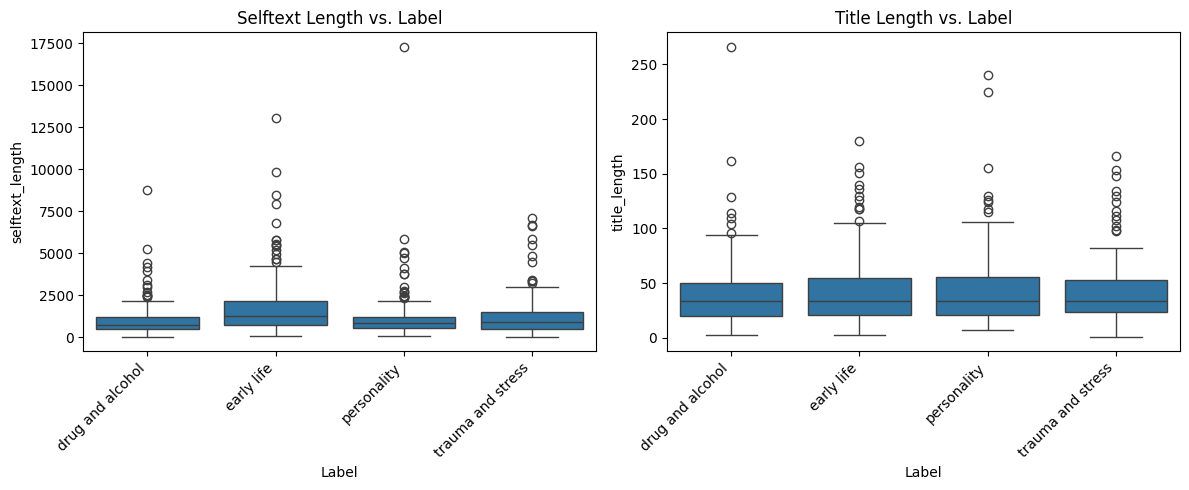

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y='selftext_length', data=df)
plt.title('Selftext Length vs. Label')
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2)
sns.boxplot(x='Label', y='title_length', data=df)
plt.title('Title Length vs. Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Boxplot of Selftext-N-Title Lengths.png"), dpi=300, bbox_inches='tight')
plt.show()

Top 10 words for drug and alcohol: [('like', 240), ('feel', 214), ('get', 149), ('know', 140), ('want', 134), ('anxiety', 125), ('even', 104), ('time', 100), ('life', 98), ('going', 97)]


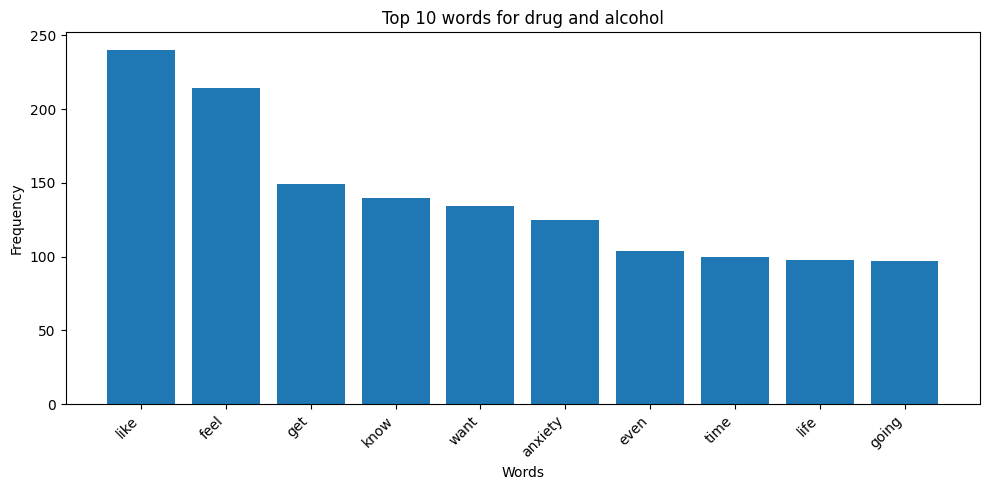

Top 10 words for early life: [('like', 409), ('feel', 292), ('would', 235), ('know', 235), ('even', 203), ('really', 198), ('get', 195), ('one', 192), ('want', 187), ('time', 175)]


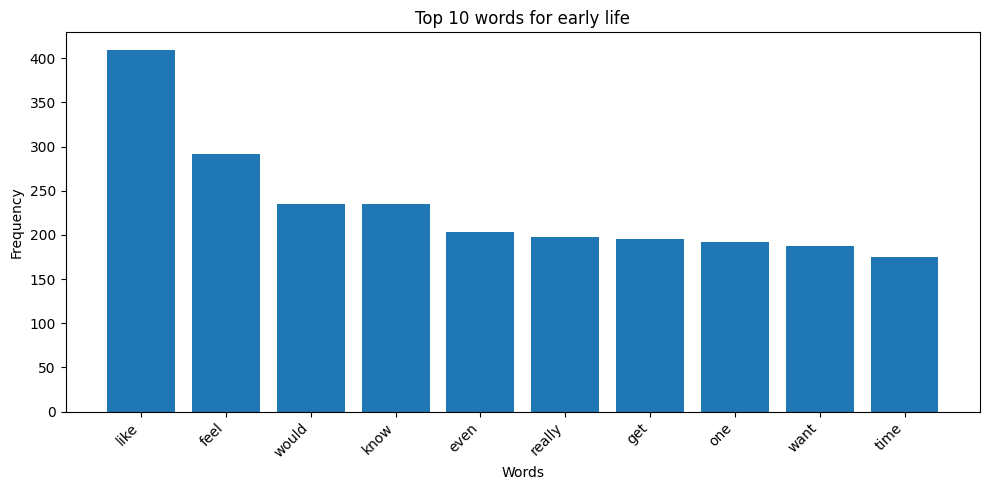

Top 10 words for personality: [('like', 347), ('feel', 297), ('know', 213), ('even', 167), ('get', 165), ('want', 157), ('people', 127), ('really', 119), ('time', 117), ('think', 109)]


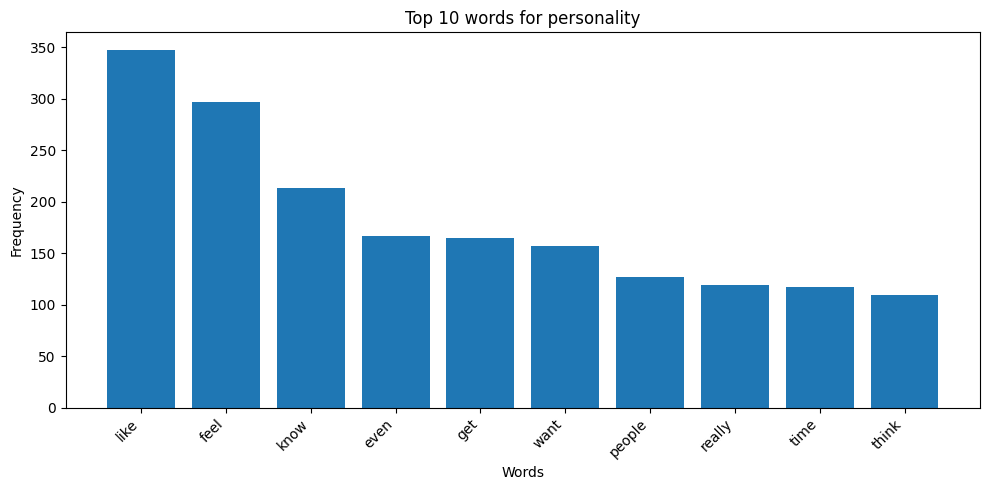

Top 10 words for trauma and stress: [('like', 281), ('feel', 250), ('get', 178), ('know', 176), ('want', 174), ('even', 171), ('really', 136), ('time', 131), ('one', 124), ('people', 119)]


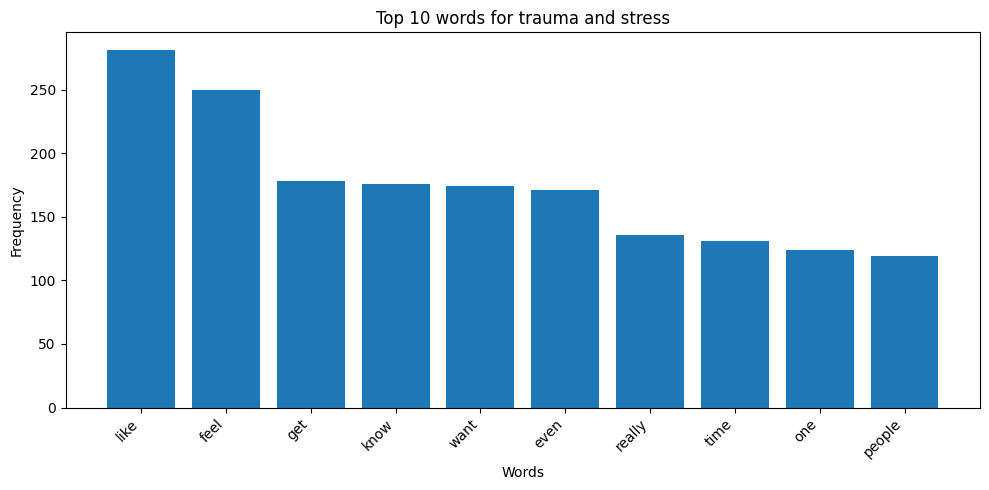

In [19]:
stop_words = set(stopwords.words('english'))

def prep_text(text):
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words and word.isalnum()]
    return words

top_words = {}
for label in df['Label'].unique():
    text = " ".join(df[df['Label'] == label]['selftext'] + " " + df[df['Label'] == label]['title'])
    words = prep_text(text)
    word_counts = Counter(words)
    top_words[label] = word_counts.most_common(10)

for label, words in top_words.items():
    print(f"Top 10 words for {label}: {words}")
    plt.figure(figsize=(10, 5))
    plt.bar(*zip(*words))
    plt.title(f"Top 10 words for {label}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, f"Top 10 words for {label}.png"), dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')  
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

df['combined_text'] = df.apply(lambda row: preprocess_text(row['selftext']) + " " + preprocess_text(row['title']), axis=1)

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['Label'])

df_prepared = df[['combined_text', 'encoded_label']].copy()

display(df_prepared.head())

[nltk_data] Downloading package punkt to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,combined_text,encoded_label
0,tri watch documentari anxiou america kinda mad...,0
1,current lay bed wide awak feel tire mind let r...,0
2,second time tri weed first time felt close not...,0
3,post rather fiancé debilit panic disord wake e...,0
4,21 year old male deal anxieti ever sinc rememb...,0


In [25]:
# Initialize TfidfVectorizer with parameters to potentially encourage overfitting
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

# Fit and transform the 'combined_text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df_prepared['combined_text'])

# Convert the sparse matrix to a dense NumPy array
tfidf_matrix_dense = tfidf_matrix.toarray()

print(tfidf_matrix_dense.shape)

(800, 5000)


In [ ]:

with open('data/tfidf_data.pkl', 'wb') as file:
    pickle.dump((tfidf_matrix_dense, df_prepared), file)